# Logistic Regression

The German Credit data set contains observations on 20 variables for 1000 past applicants for credit. Each applicant was rated as “good credit” (700 cases) or “bad credit” (300 cases).

New applicants for credit can also be evaluated on these 20 "predictor" variables. We want to develop a
credit scoring rule that can be used to determine if a new applicant is a good credit risk or a bad credit risk,
based on values for one or more of the predictor variables.

This is a case of Supervised Machine Learning - the predicted / dependent variable values are available in the data set. 

### From probability to odds to log of odds

Everything starts with the concept of probability.  Assume that the probability of success of some event is .8.  Then the probability of failure is 1- .8 = .2.  The odds of success are defined as the ratio of the probability of success over the probability of failure.  In our example, the odds of success are .8/.2 = 4.  That is to say that the odds of success are  4 to 1.  If the probability of success is .5, i.e., 50-50 percent chance, then the odds of success is 1 to 1.

The transformation from probability to odds is a monotonic transformation, meaning the odds increase as the probability increases or vice versa.  Probability ranges from 0 and 1.  Odds range from 0 and positive infinity.

## The Logistic Regression Model
The probability of occurrence of the event is non-linear. We do not consider the probability directly, instead we phrase the regression problem in terms of the odds of occurrence.

How is probability related to odds? If _y_ is the probability of occurrence, then $ \displaystyle \frac{y}{1-y} $ is the `odds ratio`. 

Whereas in Linear Regression \begin{equation} y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots \end{equation}

in logistic regression the `odds ratio` follows a non-linear function. 

In particular, the log of the odds ratio follows a linear model, i.e.
\begin{equation} \ln\left( \frac{y}{1-y} \right) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots \end{equation}

In logistic regression, a coefficient $\beta_j$ signifies that if $x_j$ is changed by 1, the log of the odds that y occurs will go up by $\beta_j$.

Solving for _y_, we get \begin{equation} y = \frac{e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots }}{1+e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots }} \end{equation}

When outcomes are categorical, it is much easier to think about the outcome in terms of probabilities and odds ratios
These are the quantities that are usually reported and described in an analysis, rather than the regression coefficients
themselves.

In [1]:
library(ROCR)
library(Metrics)
library(gplots)
library(stats)
library(DAAG)
options(repr.plot.width=5, repr.plot.height=3)

r <- read.csv("german.csv")
r2 <- r[,c(1:8,12:13,21)]
colnames(r2)
r2$Default_status <- ifelse(r2$Default_status==0,'Good','Bad')
r2$Default_status <-as.factor(r2$Default_status)

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: lattice


[1] "Status.of.existing.checking.account"                
 [2] "Duration.in.month"                                  
 [3] "Credit.history"                                     
 [4] "Purpose"                                            
 [5] "Credit.amount"                                      
 [6] "Savings.account.bonds"                              
 [7] "Present.employment.since."                          
 [8] "Installment.rate.in.percentage.of.disposable.income"
 [9] "Property"                                           
[10] "Age.in.Years"                                       
[11] "Default_status"

We define some functions that we will use later in this workshop session

In [2]:
# Function 1: Create function to calculate percent distribution for factors
pct <- function(x){
    tbl <- table(x)
    tbl_pct <- cbind(tbl,round(prop.table(tbl)*100,2))
    colnames(tbl_pct) <- c('Count','Percentage')
    tbl_pct
}
# pct(cdata$good_bad_21)

# Function 2: function to calculate IV, WOE and Efficiency
gbpct <- function(x, y){
    mt <- as.matrix(table(as.factor(x), y)) 
    # x -> independent variable(vector), y->dependent variable(vector)
    Total <- mt[,1] + mt[,2]
    # Total observations
    Total_Pct <- round(Total/sum(mt)*100, 2)
    # Total PCT
    Bad_pct <- round((mt[,1]/sum(mt[,1]))*100, 2)
    # PCT of BAd or event or response
    Good_pct <- round((mt[,2]/sum(mt[,2]))*100, 2)
    # PCT of Good or non-event
    Bad_Rate <- round((mt[,1]/(mt[,1]+mt[,2]))*100, 2) # Bad rate or response rate
    grp_score <- round((Good_pct/(Good_pct + Bad_pct))*10, 2) # score for each group
    WOE <- round(log(Good_pct/Bad_pct)*10, 2)
    # Weight of Evidence for each group
    g_b_comp <- ifelse(mt[,1] == mt[,2], 0, 1)
    IV <- ifelse(g_b_comp == 0, 0, (Good_pct - Bad_pct)*(WOE/10)) # Information value for each group
    Efficiency <- abs(Good_pct - Bad_pct)/2
    # Efficiency for each group
    otb<-as.data.frame(cbind(mt, Good_pct, Bad_pct, Total,
    Total_Pct, Bad_Rate, grp_score,
    WOE, IV, Efficiency ))
    otb$Names <- rownames(otb)
    rownames(otb) <- NULL
    otb[,c(12,2,1,3:11)] # return IV table
}

# Function 3: Normalize using Range
normalize <- function(x) {
    return((x - min(x)) / (max(x) - min(x)))
}

In [3]:
library(caret)
library(ggplot2)
pct(r2$Default_status)

Loading required package: ggplot2

Attaching package: ‘caret’

The following objects are masked from ‘package:Metrics’:

    precision, recall



,Count,Percentage
Bad,300,30
Good,700,70


---
### Weight of Evidence(WOE)
WoE shows predictive power of an independent variable in relation to dependent variable. It
evolved with credit scoring to magnify separation power between a good customer and a bad customer , hence it is
one of the measures of separation between two classes(good/bad, yes/no, 0/1, A/B, response/no-response). It is defined
as: \begin{equation} \text{WoE} = \ln\left( \frac{\text{Proportion of non events (Good)}}{\text{Proportion of events (Bad)}} \right) \end{equation}

It is computed from the basic odds ratio:
(Proportion of Good Credit Outcomes) / (Proportion of Bad Credit Outcomes)

### Checking Account Status for WoE

Warning message in par(mfrow = c(1, 2), new = TRUE):
“calling par(new=TRUE) with no plot”

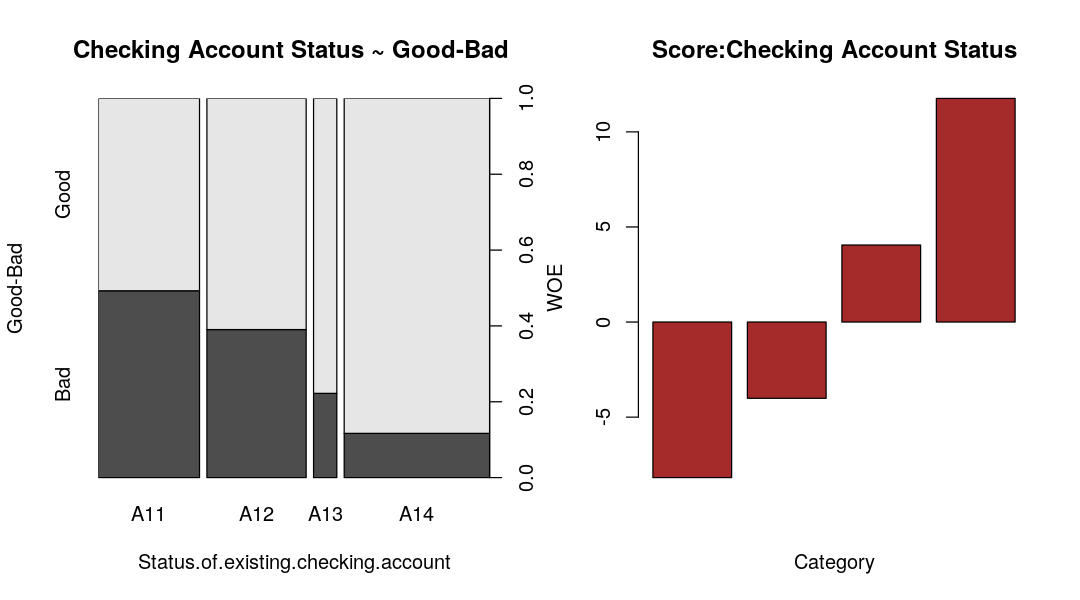

In [4]:
A1 <- gbpct(r2$Status.of.existing.checking.account,r2$Default_status)

options(repr.plot.width=9, repr.plot.height=5)
op1<-par(mfrow=c(1,2), new=TRUE)

plot(r2$Status.of.existing.checking.account, r2$Default_status,
ylab="Good-Bad", xlab="Status.of.existing.checking.account",
main="Checking Account Status ~ Good-Bad ")

barplot(A1$WOE, col="brown", names.arg=c(A1$Levels),
main="Score:Checking Account Status",
xlab="Category",
ylab="WOE",
)

WoE for Account Status 'A11' (Status.of.exisiting.checking.account) calculated below

In [5]:
goodPc <- dim(r2[r2$Default_status=='Good' & r2$Status.of.existing.checking.account=='A11',])[1]/dim(r2[r2$Default_status=='Good',])[1]
badPc <- dim(r2[r2$Default_status=='Bad' & r2$Status.of.existing.checking.account=='A11',])[1]/dim(r2[r2$Default_status=='Bad',])[1]
#goodPc; badPc
WoE <- log(goodPc/badPc)*10
round(WoE,2)

[1] -8.18

---
### Information Value(IV)

IV helps to select variables by using their order of importance w.r.to information value after grouping.
\begin{equation} \text{IV} = \sum \left( \text{% Non-events}-\text{% Events} \right)* WoE\end{equation}

IV (Information Value) for Account Status 'A11' calculated below

In [6]:
pcGood <- 100*goodPc
pcBad <- 100*badPc
IV <- (pcGood-pcBad)*WoE/10
round(IV,2)

[1] 20.57

---
### Efficiency
\begin{equation}  \text{Efficiency} = \text{Abs} \left( \text{% Non-events}- \text{% Events} \right)/2       \end{equation} 


We may split the data (given population) into random samples with 50-50, 60-40 or 70-30 ratios for Training (Development
Sample on which model will be developed or trained) and Test (validation/holdout sample on which model will be tested)
based on population size. In this workshop session we will split the sample into 70-30. 

Stratified random sampling is a method of sampling that involves the division of a population into smaller groups known as strata. In stratified random sampling, the strata are formed based on members’ shared attributes or characteristics. 

In our case we will use good_bad as strata and partition data into 70%-30% as train and test sets. You may also
split them into 60-40 or 50-50 ratio.

In [7]:
A1

Names,Good,Bad,Good_pct,Bad_pct,Total,Total_Pct,Bad_Rate,grp_score,WOE,IV,Efficiency
A11,139,135,19.86,45.00,274,27.4,49.27,3.06,-8.18,20.56452,12.570
A12,164,105,23.43,35.00,269,26.9,39.03,4.01,-4.01,4.63957,5.785
A13,49,14,7.00,4.67,63,6.3,22.22,6.00,4.05,0.94365,1.165
A14,348,46,49.71,15.33,394,39.4,11.68,7.64,11.76,40.43088,17.190


For Account Status  
* Information Value is  $\textbf{66.58}$
* Efficiency is          $\textbf{36.71}$

---
### Information Value(IV)

IV helps to select variables by using their order of importance w.r.to information value after grouping.
\begin{equation} \text{IV} = \sum \left( \text{% Non-events}-\text{% Events} \right) * \text{WoE} \end{equation}

---
### Efficiency
\begin{equation}  \text{Efficiency} = \text{Abs} \left( \text{% Non-events}- \text{% Events} \right)/2       \end{equation} 


We may split the data (given population) into random samples with 50-50, 60-40 or 70-30 ratios for Training (Development
Sample on which model will be developed or trained) and Test (validation/holdout sample on which model will be tested)
based on population size. In this workshop session we will split the sample into 70-30. 

Stratified random sampling is a method of sampling that involves the division of a population into smaller groups known as strata. In stratified random sampling, the strata are formed based on members’ shared attributes or characteristics. 

In our case we will use good_bad as strata and partition data into 70%-30% as train and test sets. You may also
split them into 60-40 or 50-50 ratio.

In [8]:
div_part_1 <- createDataPartition(y = r2$Default_status, p = 0.7, list = F)
set.seed(7)

# Training Sample
train_1 <- r2[div_part_1,] # 70% here
pct(train_1$Default_status)

,Count,Percentage
Bad,210,30
Good,490,70


In [9]:
# Test Sample
test_1 <- r2[-div_part_1,] # rest of the 30% data goes here
pct(test_1$Default_status)

,Count,Percentage
Bad,90,30
Good,210,70


In [10]:
# Model: Stepwise Logistic Regression Model
m1 <- glm(Default_status ~.,data=train_1,family=binomial())
m1 <- step(m1)

Start:  AIC=700.67
Default_status ~ Status.of.existing.checking.account + Duration.in.month + 
    Credit.history + Purpose + Credit.amount + Savings.account.bonds + 
    Present.employment.since. + Installment.rate.in.percentage.of.disposable.income + 
    Property + Age.in.Years

                                                      Df Deviance    AIC
- Property                                             3   638.51 696.51
<none>                                                     636.67 700.67
- Age.in.Years                                         1   639.26 701.26
- Credit.amount                                        1   640.97 702.97
- Duration.in.month                                    1   644.37 706.37
- Installment.rate.in.percentage.of.disposable.income  1   644.77 706.77
- Present.employment.since.                            4   651.44 707.44
- Savings.account.bonds                                4   656.11 712.11
- Credit.history                                       4   6

In [11]:
summary(m1)


Call:
glm(formula = Default_status ~ Status.of.existing.checking.account + 
    Duration.in.month + Credit.history + Purpose + Credit.amount + 
    Savings.account.bonds + Present.employment.since. + Installment.rate.in.percentage.of.disposable.income + 
    Age.in.Years, family = binomial(), data = train_1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6224  -0.7043   0.3832   0.7263   2.0586  

Coefficients:
                                                      Estimate Std. Error
(Intercept)                                         -2.846e-01  8.460e-01
Status.of.existing.checking.accountA12               4.939e-01  2.620e-01
Status.of.existing.checking.accountA13               8.427e-01  4.075e-01
Status.of.existing.checking.accountA14               1.815e+00  2.783e-01
Duration.in.month                                   -3.235e-02  1.079e-02
Credit.historyA31                                    1.447e-01  6.302e-01
Credit.historyA32                         

In [12]:
# List of significant variables and features with p-value <0.01

significant.variables <- summary(m1)$coeff[-1,4] < 0.01
names(significant.variables)[significant.variables == TRUE]
summary(m1)$coeff[row.names(summary(m1)$coeff) %in% names(significant.variables)[significant.variables == TRUE],]

[1] "Status.of.existing.checking.accountA14"             
[2] "Duration.in.month"                                  
[3] "Credit.historyA34"                                  
[4] "PurposeA41"                                         
[5] "PurposeA43"                                         
[6] "Savings.account.bondsA65"                           
[7] "Installment.rate.in.percentage.of.disposable.income"

,Estimate,Std. Error,z value,Pr(>|z|)
Status.of.existing.checking.accountA14,1.81519906,0.27834363,6.521432,6.963929e-11
Duration.in.month,-0.03234922,0.01078887,-2.998387,2.714125e-03
Credit.historyA34,1.70732719,0.53444882,3.194557,1.400457e-03
PurposeA41,1.87133582,0.43519626,4.299981,1.708124e-05
PurposeA43,1.17357917,0.29187186,4.020871,5.798329e-05
Savings.account.bondsA65,1.15413675,0.31247076,3.693583,2.211162e-04
Installment.rate.in.percentage.of.disposable.income,-0.28795678,0.09905192,-2.907130,3.647620e-03


,prob,res
1,0.9649701,0.2670511
2,0.3643078,-0.9518833
5,0.1959855,-0.6605119
6,0.6737132,0.8887640
9,0.9927982,0.1202317
11,0.3434424,-0.9173275


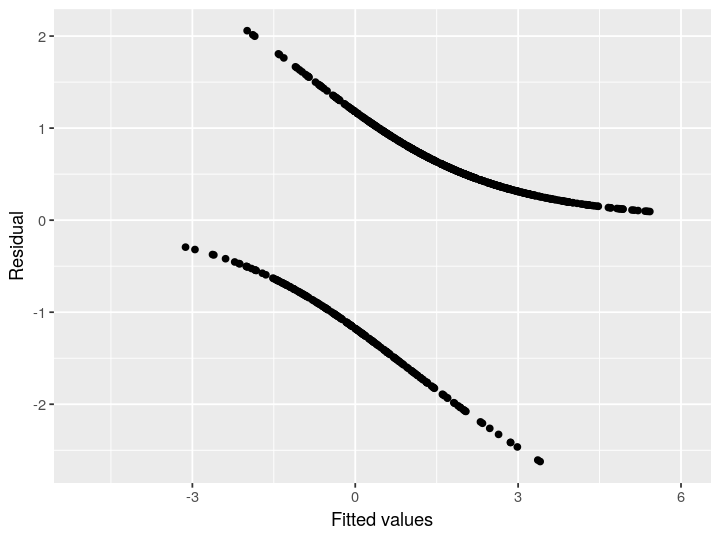

In [13]:
prob <- predict(m1, type = "response")
res <- residuals(m1, type = "deviance")
head(cbind(prob,res))
options(repr.plot.width=6, repr.plot.height=4.5)
#Plot Residuals
#plot(predict(m1), res, xlab="Fitted values", ylab = "Residuals", ylim = max(abs(res)) * c(-1,1))
qplot(predict(m1), res, ylab="Residual", xlab="Fitted values", xlim=c(-5,6))

In [14]:
## CIs using profiled log-likelihood
confint(m1)

Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),-1.9556008371,1.370287e+00
Status.of.existing.checking.accountA12,-0.0173986332,1.010990e+00
Status.of.existing.checking.accountA13,0.0629109616,1.668770e+00
Status.of.existing.checking.accountA14,1.2796608797,2.373010e+00
Duration.in.month,-0.0537205932,-1.130606e-02
Credit.historyA31,-1.0836932595,1.400081e+00
Credit.historyA32,-0.1636723312,1.846495e+00
Credit.historyA33,-0.5485943803,1.669029e+00
Credit.historyA34,0.6824711960,2.790529e+00
PurposeA41,1.0496992553,2.763901e+00


In [15]:
## odds ratios and 95% CI
exp(cbind(OR = coef(m1), confint(m1)))

Waiting for profiling to be done...


,OR,2.5 %,97.5 %
(Intercept),0.7523032,0.1414794,3.9364812
Status.of.existing.checking.accountA12,1.6386718,0.9827518,2.7483208
Status.of.existing.checking.accountA13,2.3226303,1.0649320,5.3056357
Status.of.existing.checking.accountA14,6.1422987,3.5954202,10.7296415
Duration.in.month,0.9681684,0.9476969,0.9887576
Credit.historyA31,1.1557134,0.3383436,4.0555289
Credit.historyA32,2.2571328,0.8490202,6.3375688
Credit.historyA33,1.7061005,0.5777614,5.3070115
Credit.historyA34,5.5142034,1.9787616,16.2896346
PurposeA41,6.4969694,2.8567918,15.8615948


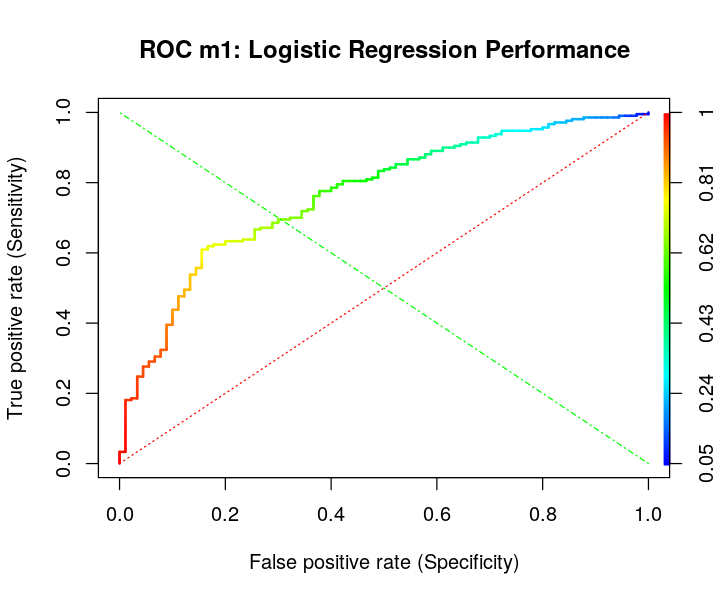

In [16]:
#score test data set
test_1$m1_score <- predict(m1,type='response',test_1)
m1_pred <- prediction(test_1$m1_score, test_1$Default_status)
m1_perf <- performance(m1_pred,"tpr","fpr")

#ROC
options(repr.plot.width=6, repr.plot.height=5)
plot(m1_perf, lwd=2, colorize=TRUE, main="ROC m1: Logistic Regression Performance", 
     xlab="False positive rate (Specificity)", ylab="True positive rate (Sensitivity)")
lines(x=c(0, 1), y=c(0, 1), col="red", lwd=1, lty=3);
lines(x=c(1, 0), y=c(0, 1), col="green", lwd=1, lty=4)

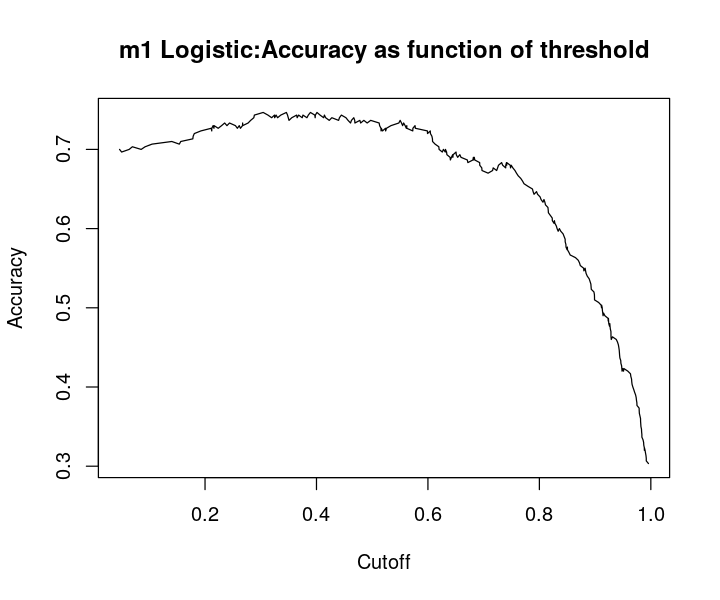

In [17]:
# Plot accuracy as function of threshold
m1_perf_acc <- performance(m1_pred, measure = "acc")
plot(m1_perf_acc, main="m1 Logistic:Accuracy as function of threshold")

###  AUROC & Gini's measure
* AUROC varies between 0.5 and 1, where 0.5 indicates chance classification and 1 indicates perfect classification
* Gini's measure lies between 0 and 1

In [18]:
# Gini & AUC m1
m1_AUROC <- round(performance(m1_pred, measure = "auc")@y.values[[1]]*100, 2)
m1_Gini <- (2*m1_AUROC - 100)
cat("AUROC: ",m1_AUROC,"\tGini:", m1_Gini, "\n")

AUROC:  76.71 	Gini: 53.42 


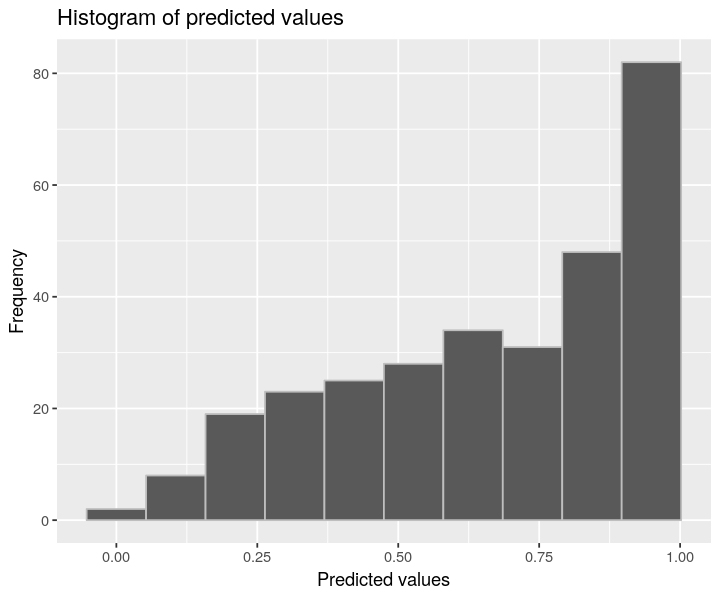

In [44]:
qplot(m1_pred@predictions[[1]], geom='histogram', bins=10, color=I("gray"), ylab='Frequency', xlab='Predicted values', main='Histogram of predicted values')

In [39]:
testaccuracy <- cbind(as.numeric(test_1$Default_status)-1, m1_pred@predictions[[1]])
cutoff <- function(ctoff) {
    t <- ifelse(testaccuracy[,2]<=ctoff,0,1)
    tb <- cbind(testaccuracy[,1],t)
    pn <- ifelse(tb[,1]==0 & tb[,2]==0,'tn',ifelse(tb[,1]==1 & tb[,2]==1,'tp',ifelse(tb[,1]==1 & tb[,2]==0,'fn','fp')))
    pn <- as.factor(pn)
    acc <- round(length(pn[pn=='tn' | pn=='tp'])*100/length(pn),2)
    return(list(ctoff,pn,acc))
}
co <- c(0.2,0.3,0.8)
t <- sapply(co,cutoff)
t[[1]]; t[[3]]; table(t[[2]])
cat('------------------------')
t[[4]]; t[[6]]; table(t[[5]])
cat('------------------------')
t[[7]]; t[[9]]; table(t[[8]])
cat('------------------------')

[1] 0.2

[1] 72.67


 fn  fp  tn  tp 
  3  79  11 207 

------------------------

[1] 0.3

[1] 74.67


 fn  fp  tn  tp 
 11  65  25 199 

------------------------

[1] 0.8

[1] 64


 fn  fp  tn  tp 
 95  13  77 115 

------------------------